In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW  
import warnings
warnings.filterwarnings('ignore')

In [50]:
!pip install -q transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Load the data


In [44]:
print("Loading the dataset...")
data = pd.read_csv('/kaggle/input/dataset-10/cleaned_data.csv', encoding='latin-1')
print(f"Dataset shape: {data.shape}")

Loading the dataset...
Dataset shape: (5169, 2)


# Display first few rows


In [45]:
print("\nFirst few rows of the dataset:")
print(data.head())


First few rows of the dataset:
   Label                                              email
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


# Class distribution


In [46]:
print("\nClass distribution:")
class_counts = data['Label'].value_counts()
print(class_counts)
print("Class distribution percentage:")
print(data['Label'].value_counts(normalize=True) * 100)


Class distribution:
Label
0    4516
1     653
Name: count, dtype: int64
Class distribution percentage:
Label
0    87.366996
1    12.633004
Name: proportion, dtype: float64


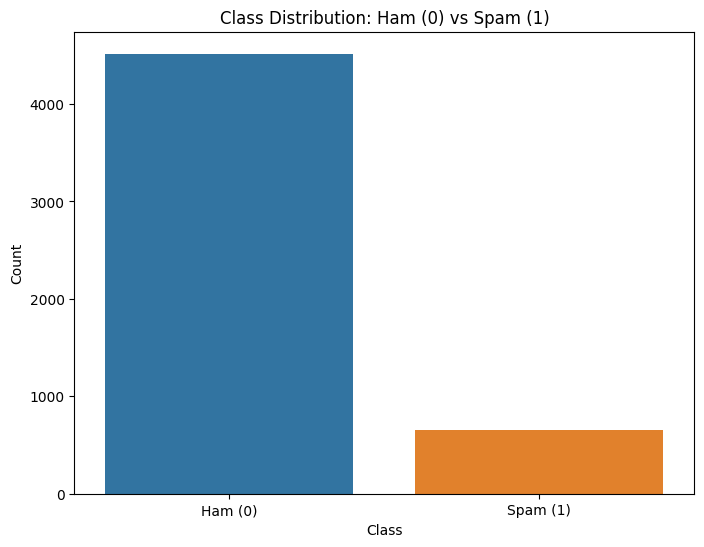

In [47]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=data)
plt.title('Class Distribution: Ham (0) vs Spam (1)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Ham (0)', 'Spam (1)'])
plt.show()

# Prepare data

In [48]:
X = data['email']
y = data['Label']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [51]:
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training class distribution: {pd.Series(y_train).value_counts()}")
print(f"Testing class distribution: {pd.Series(y_test).value_counts()}")


Training set size: 4135
Test set size: 1034
Training class distribution: Label
0    3613
1     522
Name: count, dtype: int64
Testing class distribution: Label
0    903
1    131
Name: count, dtype: int64


# Create a PyTorch dataset for the BERT model


In [52]:
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx] if hasattr(self.texts, 'iloc') else self.texts[idx])
        label = self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Load pre-trained BERT tokenizer and model


In [53]:
print("\nLoading BERT tokenizer and model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Create datasets and dataloaders
train_dataset = EmailDataset(X_train, y_train, tokenizer)
test_dataset = EmailDataset(X_test, y_test, tokenizer)

# Define dataloaders - handle class imbalance through class weights in loss function
batch_size = 16

# Calculate class weights for imbalanced data
num_ham = class_counts[0]
num_spam = class_counts[1]
total = num_ham + num_spam
weight_for_0 = (1 / num_ham) * (total / 2.0)
weight_for_1 = (1 / num_spam) * (total / 2.0)

class_weights = torch.FloatTensor([weight_for_0, weight_for_1])
print(f"\nClass weights: Ham={weight_for_0:.4f}, Spam={weight_for_1:.4f}")

# Create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


Loading BERT tokenizer and model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Class weights: Ham=0.5723, Spam=3.9579


# Training 


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
class_weights = class_weights.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Define loss function with class weights to balancing the classes
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

Using device: cuda


In [55]:
# Training loop
print("\nTraining the model...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print('-' * 10)
    
    # Training
    model.train()
    total_train_loss = 0
    
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        model.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        
        total_train_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")
    
    # Evaluation during training
    model.eval()
    val_predictions = []
    val_true_labels = []
    
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        
        val_predictions.extend(preds.cpu().tolist())
        val_true_labels.extend(labels.cpu().tolist())
    
    # Print evaluation metrics
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    print(f"Validation Accuracy: {val_accuracy:.4f}")




Training the model...

Epoch 1/3
----------
Average training loss: 0.1567
Validation Accuracy: 0.9913

Epoch 2/3
----------
Average training loss: 0.0583
Validation Accuracy: 0.9913

Epoch 3/3
----------
Average training loss: 0.0235
Validation Accuracy: 0.9923


# Evaluation


Final Evaluation on Test Set...
Test Accuracy: 0.9923

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      1.00       903
        Spam       0.99      0.95      0.97       131

    accuracy                           0.99      1034
   macro avg       0.99      0.97      0.98      1034
weighted avg       0.99      0.99      0.99      1034



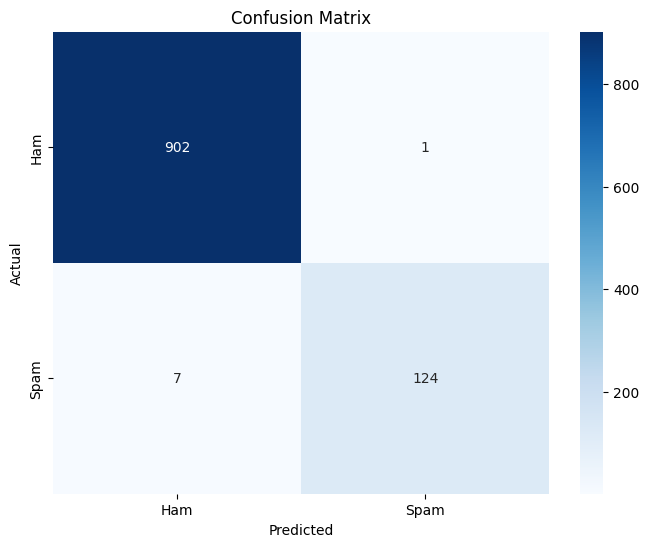

In [56]:
print("\nFinal Evaluation on Test Set...")
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        
        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['Ham', 'Spam']))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Test with new data

In [57]:
# Function to make predictions on new emails
def predict_spam(email_text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer.encode_plus(
        email_text,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        _, preds = torch.max(logits, dim=1)
    
    return {
        'prediction': 'Spam' if preds.item() == 1 else 'Ham',
        'confidence': probs[0][preds.item()].item()
    }

# Example usage
example_email = "Congratulations! You've won a free vacation to the Bahamas. Click here to claim your prize now!"
result = predict_spam(example_email, model, tokenizer, device)
print("\nExample prediction:")
print(f"Email: {example_email}")
print(f"Prediction: {result['prediction']} with confidence {result['confidence']:.4f}")

# Another example
example_email2 = "Hi John, I'm sending you the meeting notes from yesterday. Please review them before Friday's call."
result2 = predict_spam(example_email2, model, tokenizer, device)
print(f"\nEmail: {example_email2}")
print(f"Prediction: {result2['prediction']} with confidence {result2['confidence']:.4f}")


Example prediction:
Email: Congratulations! You've won a free vacation to the Bahamas. Click here to claim your prize now!
Prediction: Spam with confidence 0.9986

Email: Hi John, I'm sending you the meeting notes from yesterday. Please review them before Friday's call.
Prediction: Ham with confidence 0.9925


# Save the model

In [58]:
model_save_path = 'email_spam_transformer_model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"\nModel saved to {model_save_path}")


Model saved to email_spam_transformer_model


In [59]:
import shutil
shutil.make_archive('email_spam_model', 'zip', model_save_path)

'/kaggle/working/email_spam_model.zip'